In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from itertools import product

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='/content/drive/My Drive/autoencoder/data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='/content/drive/My Drive/autoencoder/data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

In [ ]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [ ]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [ ]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img.cpu(), recon.cpu()))

Epoch:1, Loss:0.0085
Epoch:2, Loss:0.0047
Epoch:3, Loss:0.0037
Epoch:4, Loss:0.0031
Epoch:5, Loss:0.0036
Epoch:6, Loss:0.0030
Epoch:7, Loss:0.0033
Epoch:8, Loss:0.0030
Epoch:9, Loss:0.0029
Epoch:10, Loss:0.0030


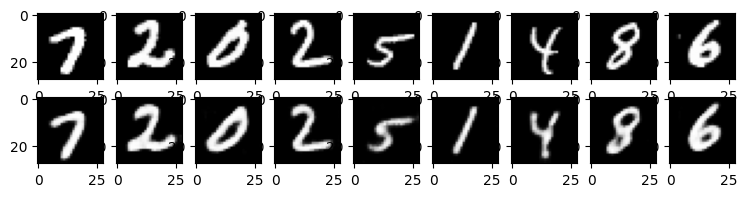

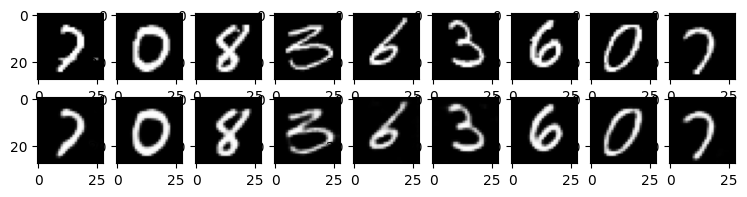

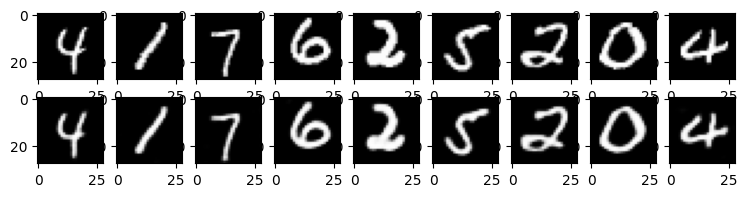

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item[0])

## Pruebas sobre el conjunto de validación

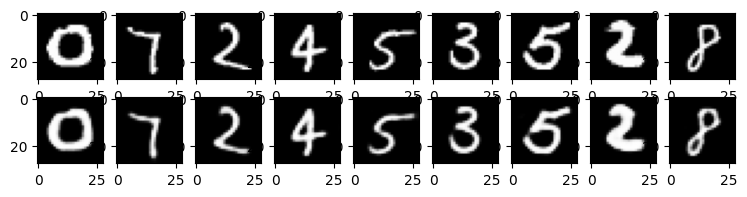

In [ ]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

images = images.to(device)

plt.figure(figsize=(9, 2))
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img = img.unsqueeze(0)  # Añade dimensión para el batch (N=1)
        img = img.to(device)

        # Predicción con el modelo
        pred = model(img)

        # Reconstrucción
        recon = pred[0].cpu().detach().numpy().squeeze()  # Mueve la salida de vuelta a la CPU y elimina dimensión extra

        # Visualización
        plt.subplot(2, 9, i+1)
        plt.imshow(img[0].cpu().numpy().squeeze())  # Original en CPU para visualización

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon)  # Reconstrucción


## Ruido

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Función para validar resultados y/o visualizarlos
def validate_autoencoder_with_noise(model, data_loader_valid, noise_factor, epoch, num_epochs, show_results, device, num_images=10):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        img, _ = next(iter(data_loader_valid))
        img = img.to(device)

        # Crear una versión de baja resolución
        noisy_image = add_noise(img, noise_factor=noise_factor)
        noisy_image = noisy_image.to(device)

        # Reconstruir la imagen
        recon = model(noisy_image)
        # Calcular la pérdida de validación
        loss = criterion(recon, img)
        val_loss += loss.item()

    val_loss /= len(data_loader_valid)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

    # Mover datos a CPU para visualización
    img = img.cpu()
    noisy_image = noisy_image.cpu()
    recon = recon.cpu()

    # Mostrar imágenes
    if show_results:
        fig, axes = plt.subplots(3, num_images, figsize=(15, 5))
        for i in range(num_images):
            axes[0, i].imshow(img[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title("Original")

            axes[1, i].imshow(noisy_image[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title("Noisy")

            axes[2, i].imshow(recon[i].squeeze(), cmap='gray')
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_title("Reconstructed")

        plt.tight_layout()
        plt.show()
    return val_loss


# Función para entrenar el modelo
def train_autoencoder_with_noise(model, data_loader, data_loader_valid, num_epochs, noise_factor, criterion, optimizer, show_results, device):
    for epoch in range(num_epochs):
        train_loss = 0
        for img, _ in data_loader:
            img = img.to(device)

            noisy_image = add_noise(img, noise_factor=noise_factor)
            noisy_image = noisy_image.to(device)

            recon = model(noisy_image)

            # Calcular la pérdida
            loss = criterion(recon, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(data_loader)  # Promedio por batch
        print(f"Epoch {epoch + 1}/{num_epochs}, Trainning Loss: {train_loss:.4f}")
        val_loss = validate_autoencoder_with_noise(model, data_loader_valid, noise_factor, epoch, num_epochs, show_results, device, num_images=10)
    return train_loss, val_loss


def add_noise(img, noise_factor=0.5):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)  # Asegurar que los valores estén entre 0 y 1



In [ ]:
# Verificar si GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hiperparámetros a explorar
learning_rates = [1e-2, 1e-3, 1e-4]
noise_factors = [0.5, 0.7, 0.9]
weight_decays = [1e-5, 1e-4, 1e-3]
num_epochs = 10


# Búsqueda de mejores hiperparámetros
results = []

for lr, noise_factor, wd in product(learning_rates, noise_factors, weight_decays):
    print(f"Training with lr={lr}, noise_factor={noise_factor}, weight_decay={wd}")

    model = Autoencoder().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    train_loss, val_loss = train_autoencoder_with_noise(model, data_loader, data_loader_valid, num_epochs, noise_factor, criterion, optimizer, False, device)

    # Guardar el resultado final
    results.append({
        "lr": lr,
        "noise_factor": noise_factor,
        "weight_decay": wd,
        "train_loss": train_loss,
        "val_loss": val_loss
    })


In [13]:
# Crear un diccionario para almacenar los mejores resultados por noise_factor
best_params_per_noise = {}

# Agrupar los resultados por noise_factor
for noise_factor in set(res["noise_factor"] for res in results):
    # Filtrar resultados para este noise_factor
    noise_results = [res for res in results if res["noise_factor"] == noise_factor]
    # Ordenar por val_loss y luego por train_loss
    best_params = sorted(noise_results, key=lambda x: (x["val_loss"], x["train_loss"]))[0]
    best_params_per_noise[noise_factor] = best_params

# Mostrar los mejores resultados por noise_factor
for noise_factor, params in best_params_per_noise.items():
    print(f"Noise Factor: {noise_factor}, Best Params: {params}")


Noise Factor: 0.5, Best Params: {'lr': 0.001, 'noise_factor': 0.5, 'weight_decay': 1e-05, 'train_loss': 0.011401343362918223, 'val_loss': 7.186437939192838e-05}
Noise Factor: 0.7, Best Params: {'lr': 0.001, 'noise_factor': 0.7, 'weight_decay': 1e-05, 'train_loss': 0.01775872156119296, 'val_loss': 0.00011587307853683545}
Noise Factor: 0.9, Best Params: {'lr': 0.001, 'noise_factor': 0.9, 'weight_decay': 0.0001, 'train_loss': 0.026935401694305035, 'val_loss': 0.00015974805281040774}


Training with lr=0.001, noise_factor=0.5, weight_decay=1e-05
Epoch 1/10, Trainning Loss: 0.0433
Epoch 1/10, Validation Loss: 0.0001


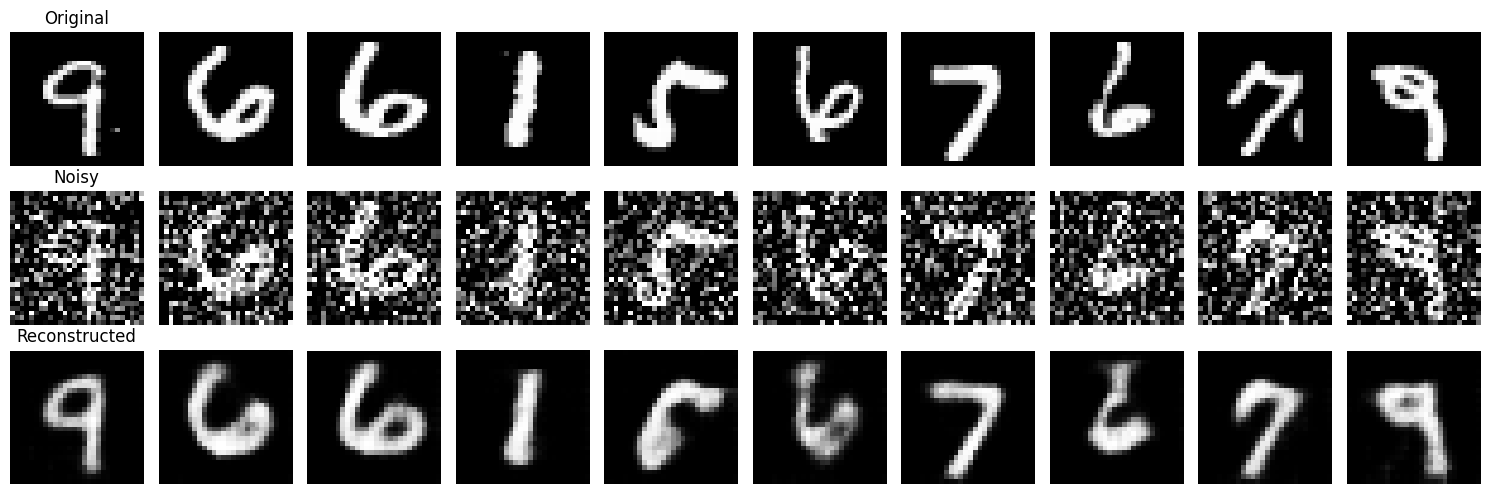

Epoch 2/10, Trainning Loss: 0.0177
Epoch 2/10, Validation Loss: 0.0001


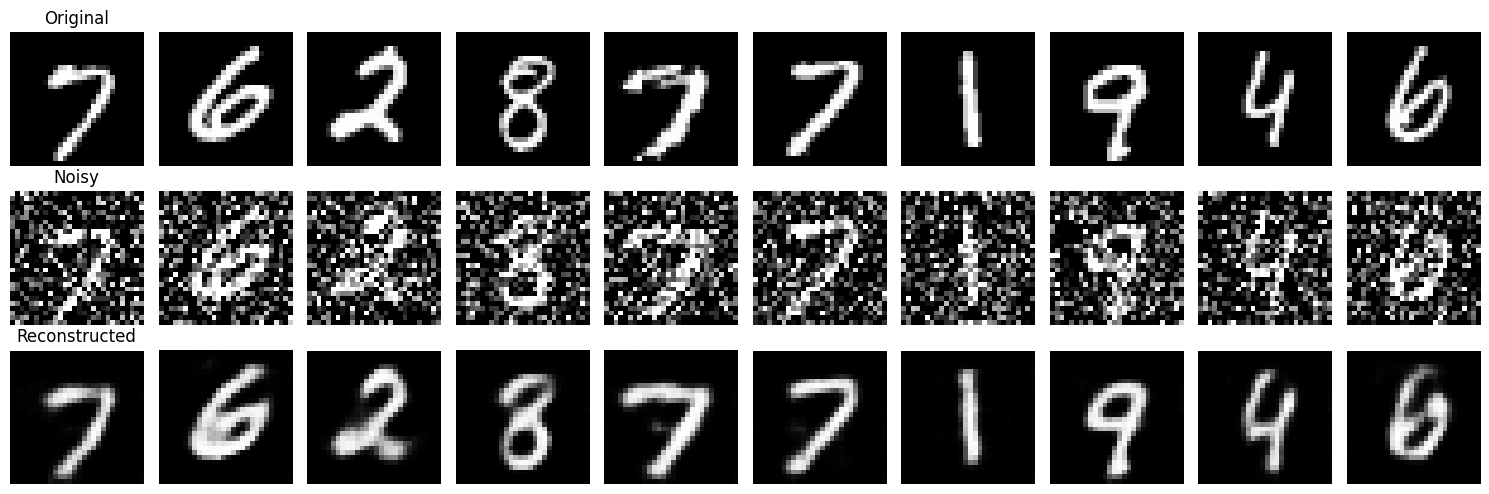

Epoch 3/10, Trainning Loss: 0.0147
Epoch 3/10, Validation Loss: 0.0001


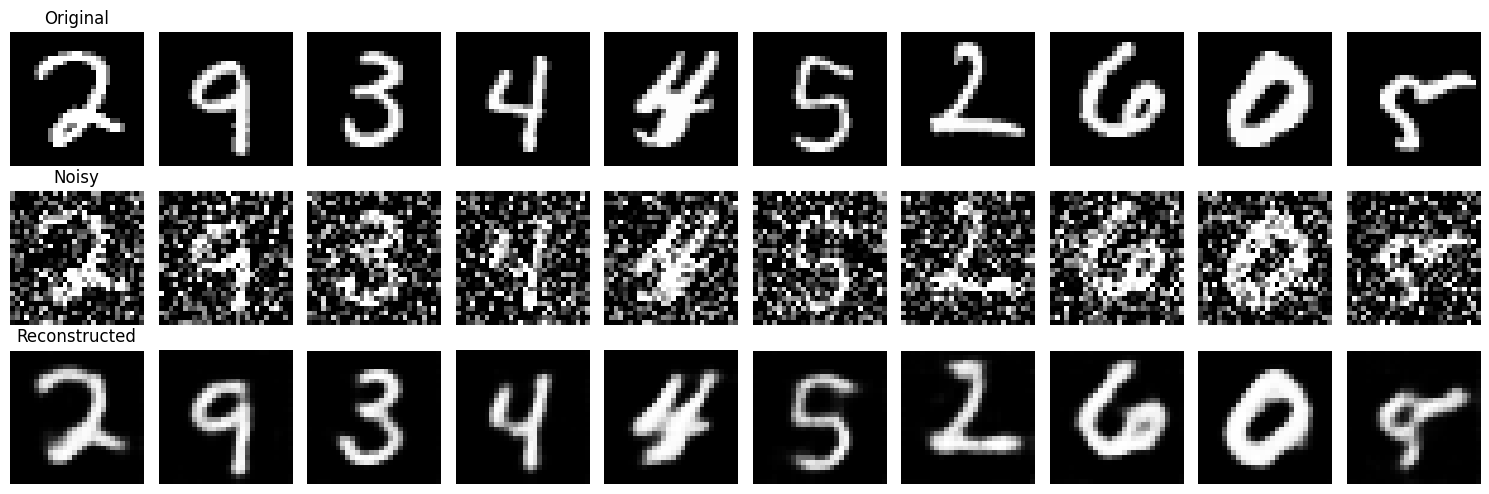

Epoch 4/10, Trainning Loss: 0.0135
Epoch 4/10, Validation Loss: 0.0001


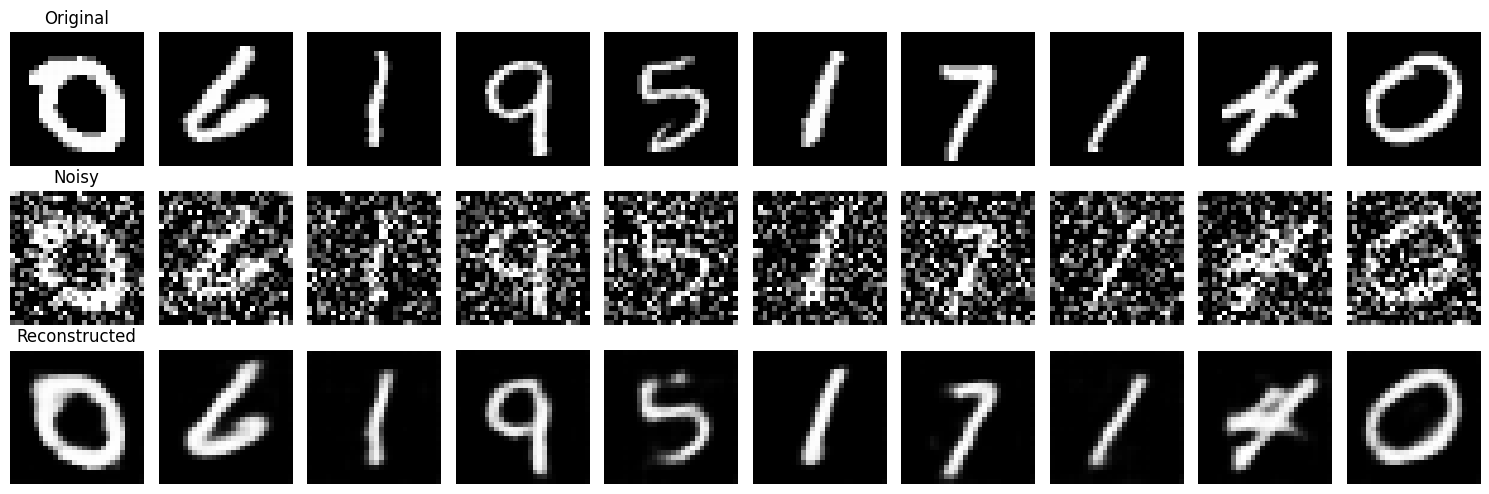

Epoch 5/10, Trainning Loss: 0.0128
Epoch 5/10, Validation Loss: 0.0001


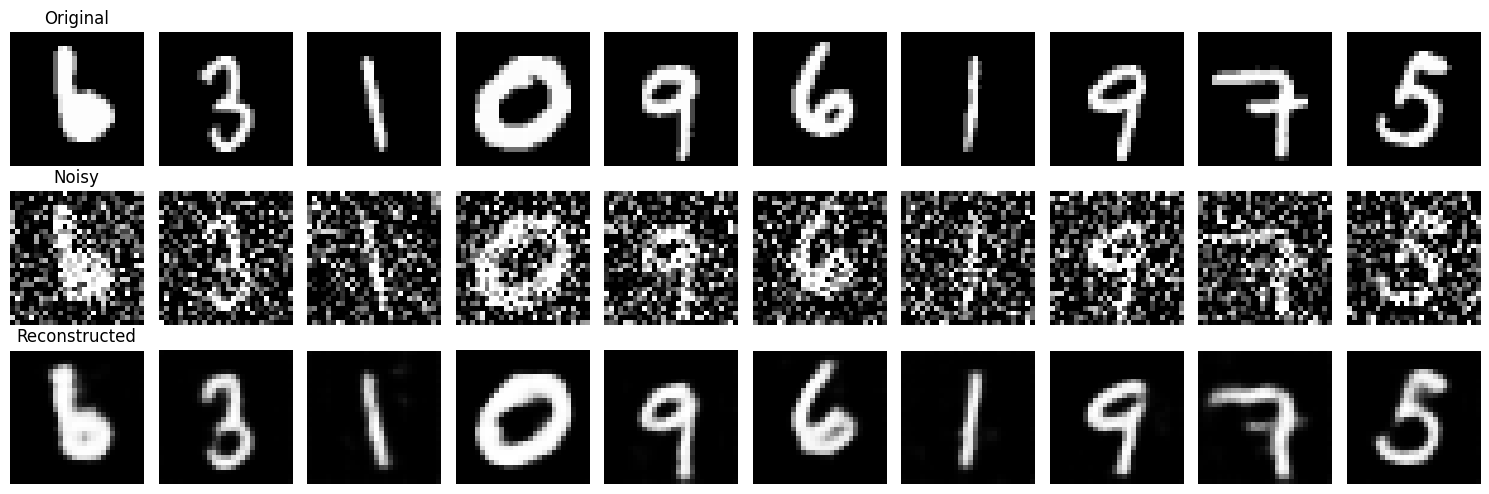

Epoch 6/10, Trainning Loss: 0.0123
Epoch 6/10, Validation Loss: 0.0001


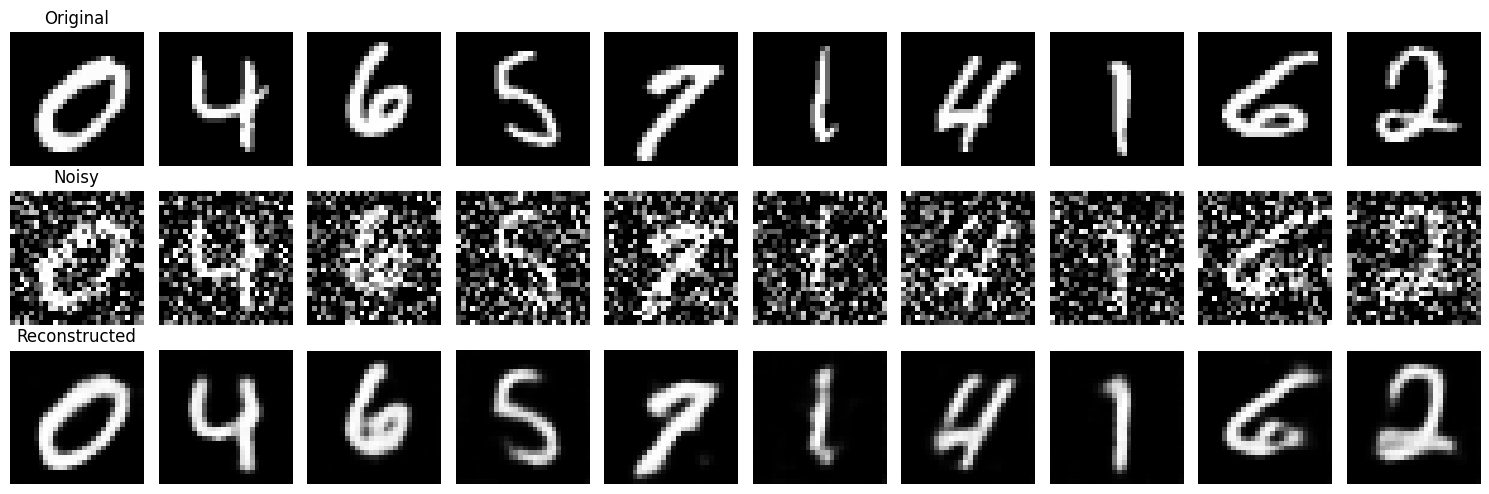

Epoch 7/10, Trainning Loss: 0.0120
Epoch 7/10, Validation Loss: 0.0001


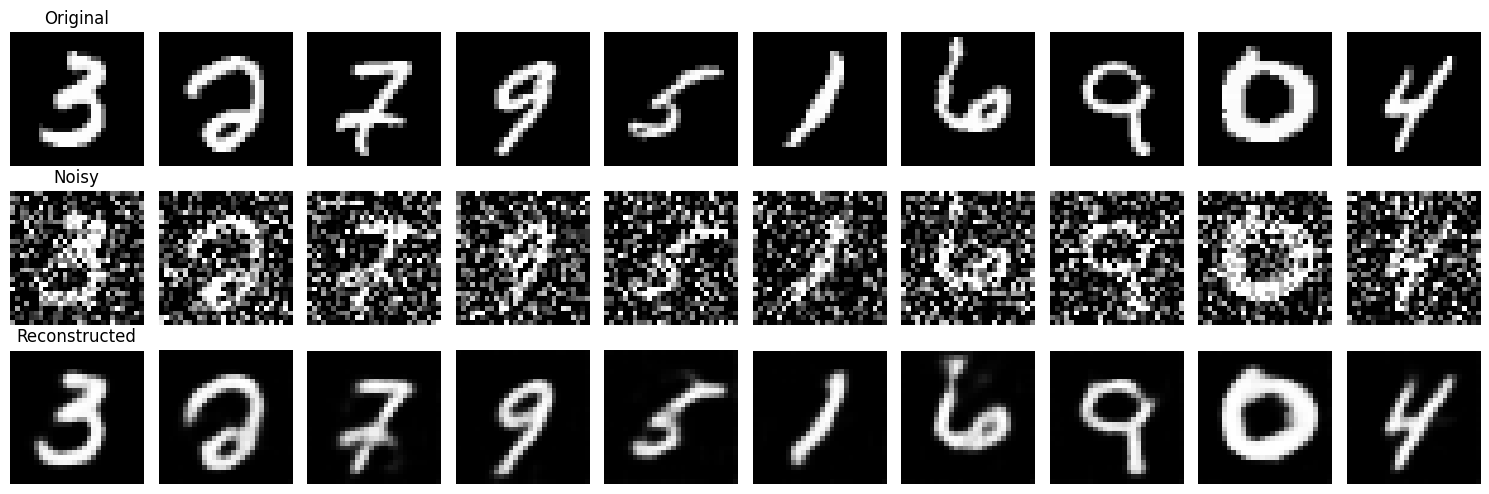

Epoch 8/10, Trainning Loss: 0.0118
Epoch 8/10, Validation Loss: 0.0001


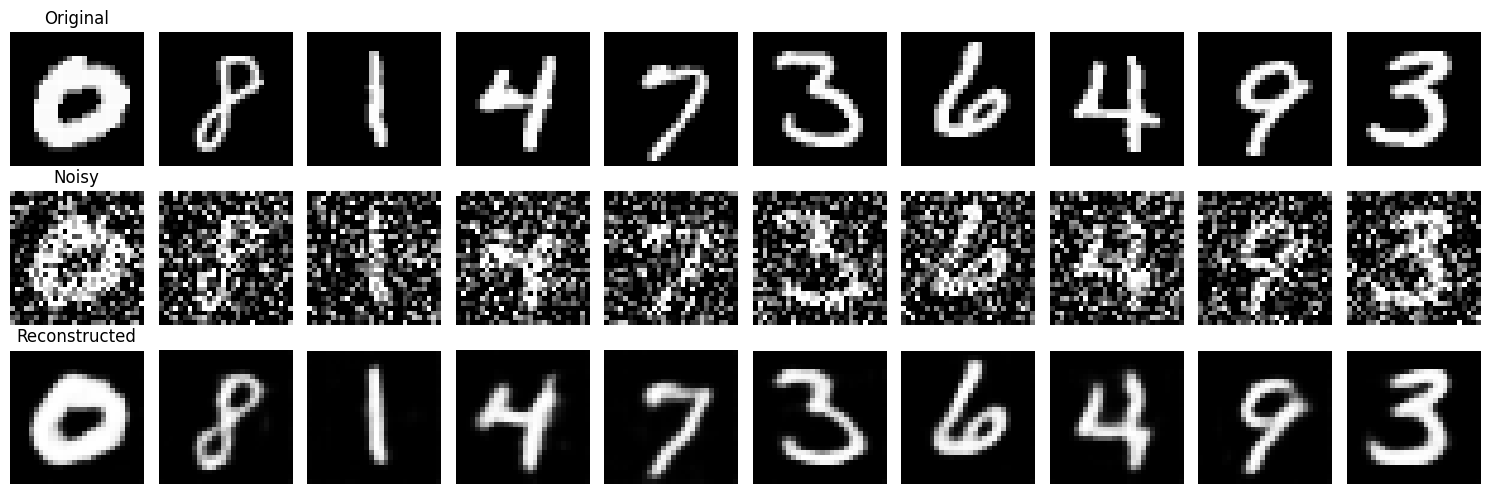

Epoch 9/10, Trainning Loss: 0.0116
Epoch 9/10, Validation Loss: 0.0001


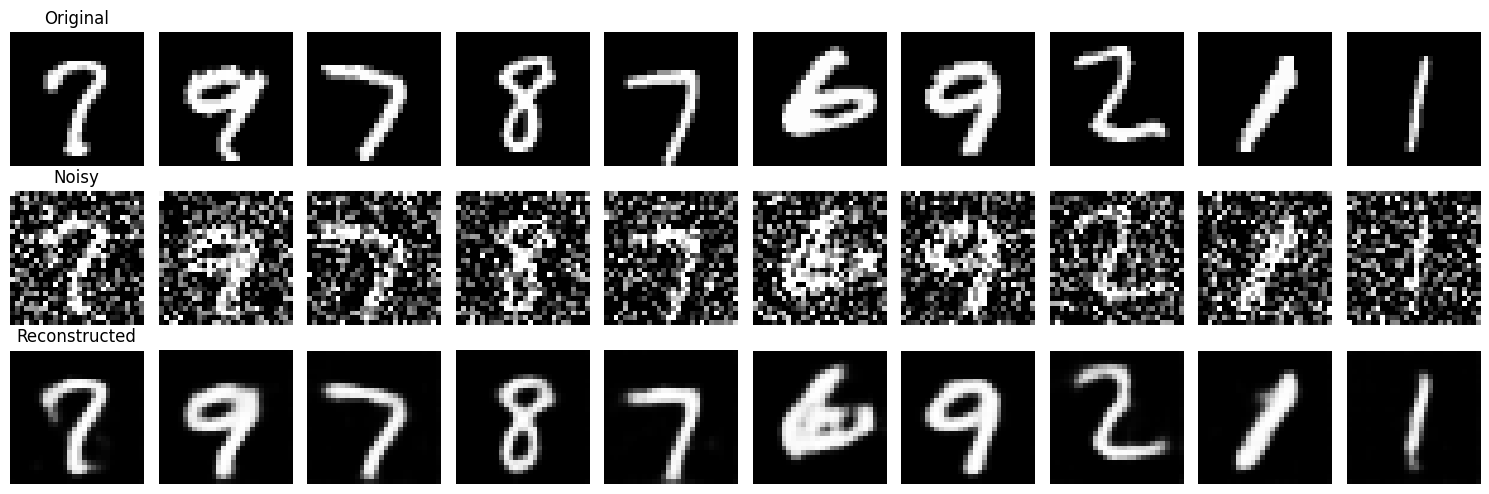

Epoch 10/10, Trainning Loss: 0.0115
Epoch 10/10, Validation Loss: 0.0001


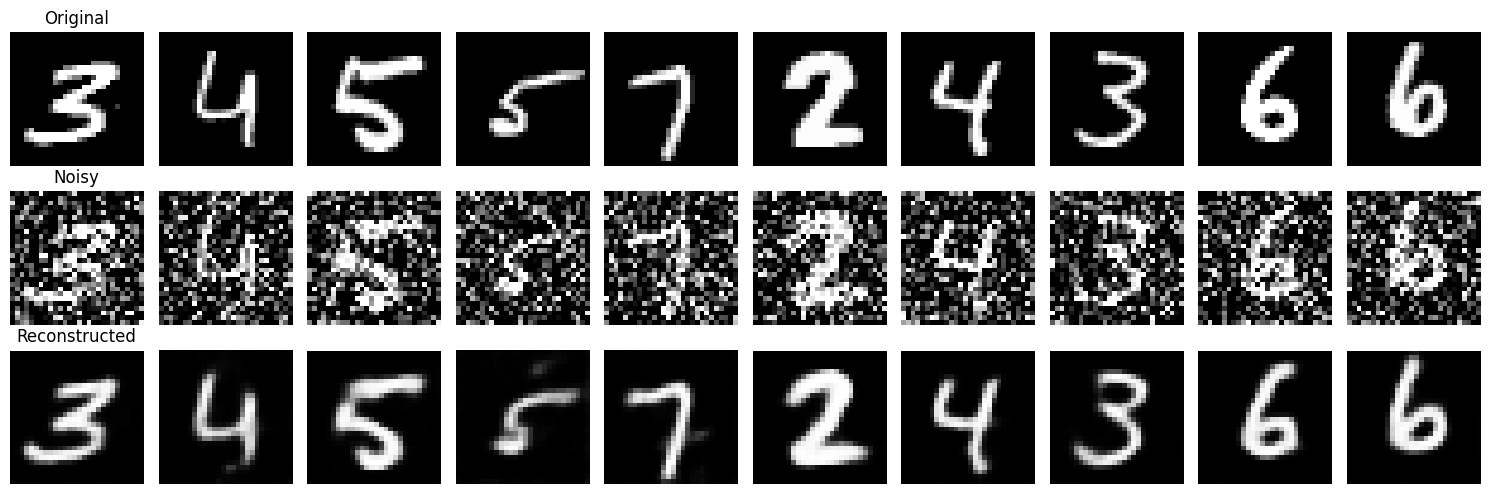

Training with lr=0.001, noise_factor=0.7, weight_decay=1e-05
Epoch 1/10, Trainning Loss: 0.0531
Epoch 1/10, Validation Loss: 0.0002


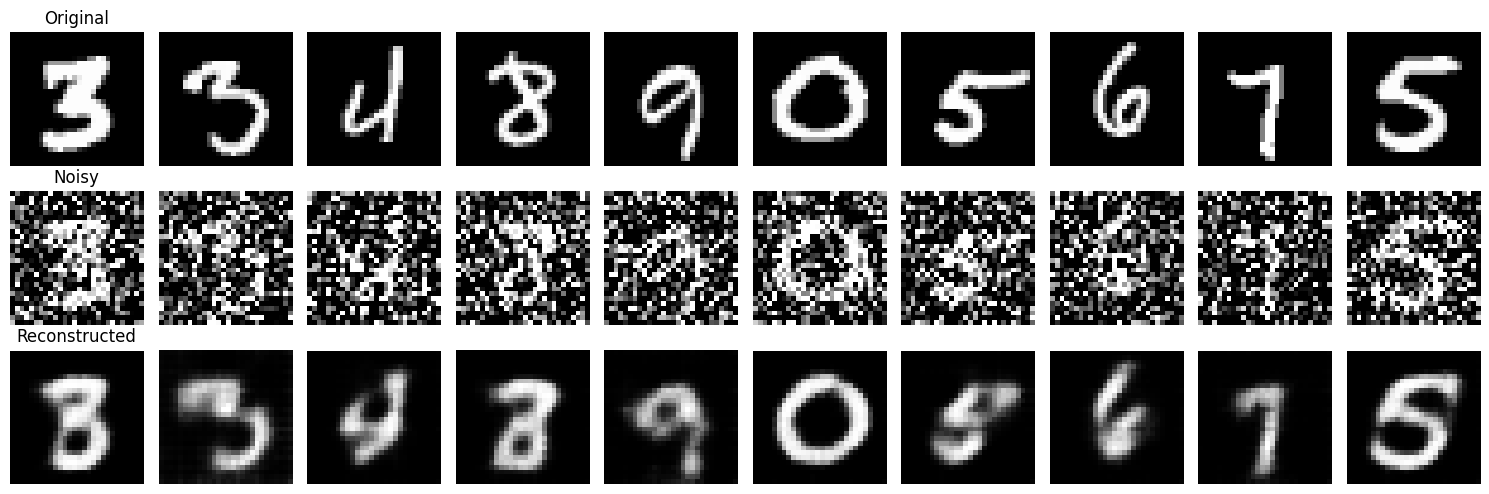

Epoch 2/10, Trainning Loss: 0.0239
Epoch 2/10, Validation Loss: 0.0001


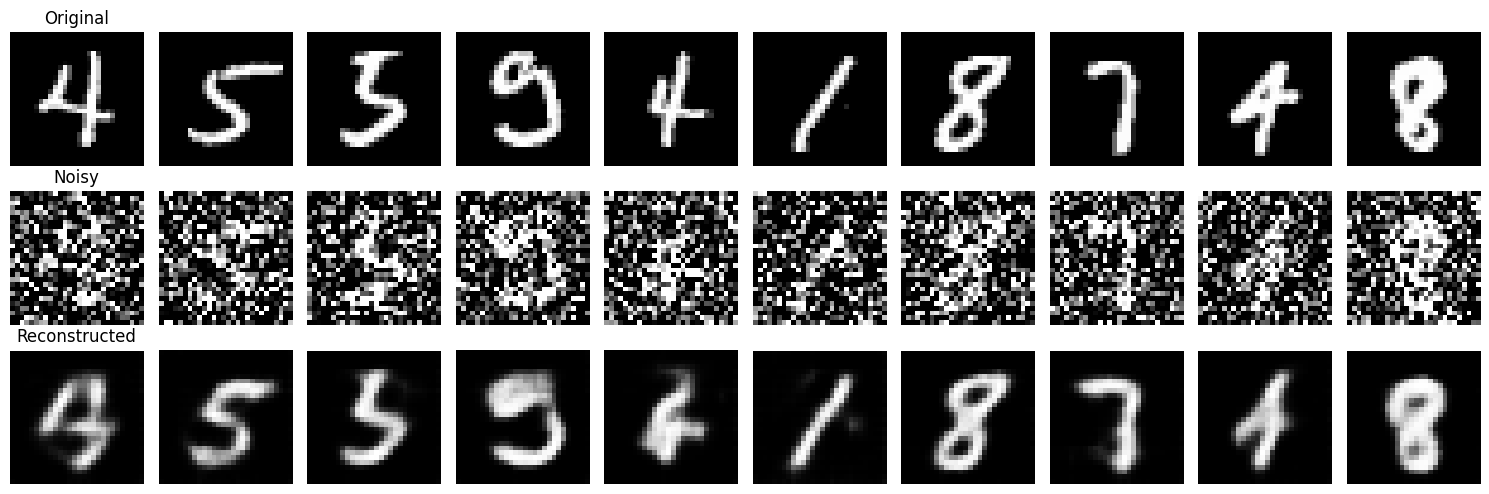

Epoch 3/10, Trainning Loss: 0.0208
Epoch 3/10, Validation Loss: 0.0001


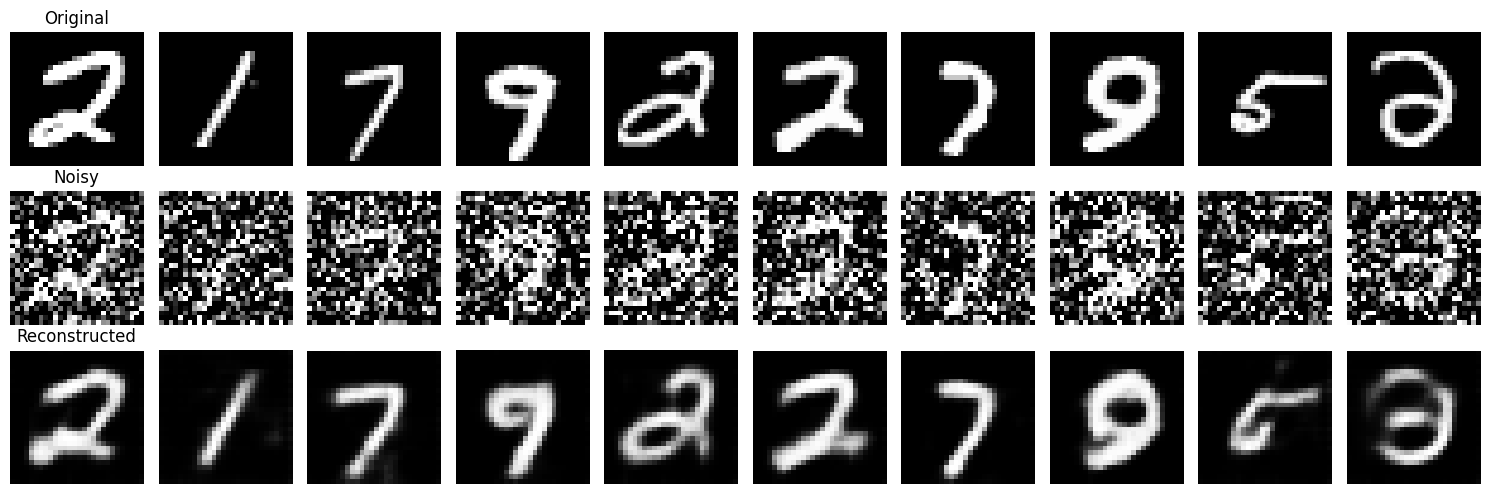

Epoch 4/10, Trainning Loss: 0.0195
Epoch 4/10, Validation Loss: 0.0001


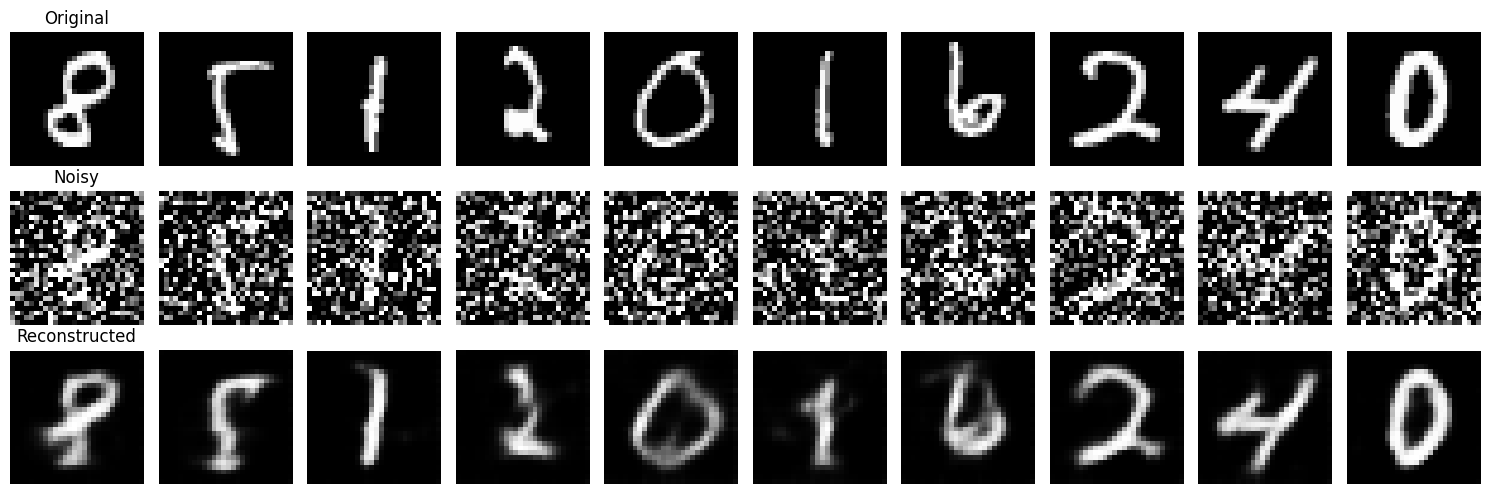

Epoch 5/10, Trainning Loss: 0.0189
Epoch 5/10, Validation Loss: 0.0001


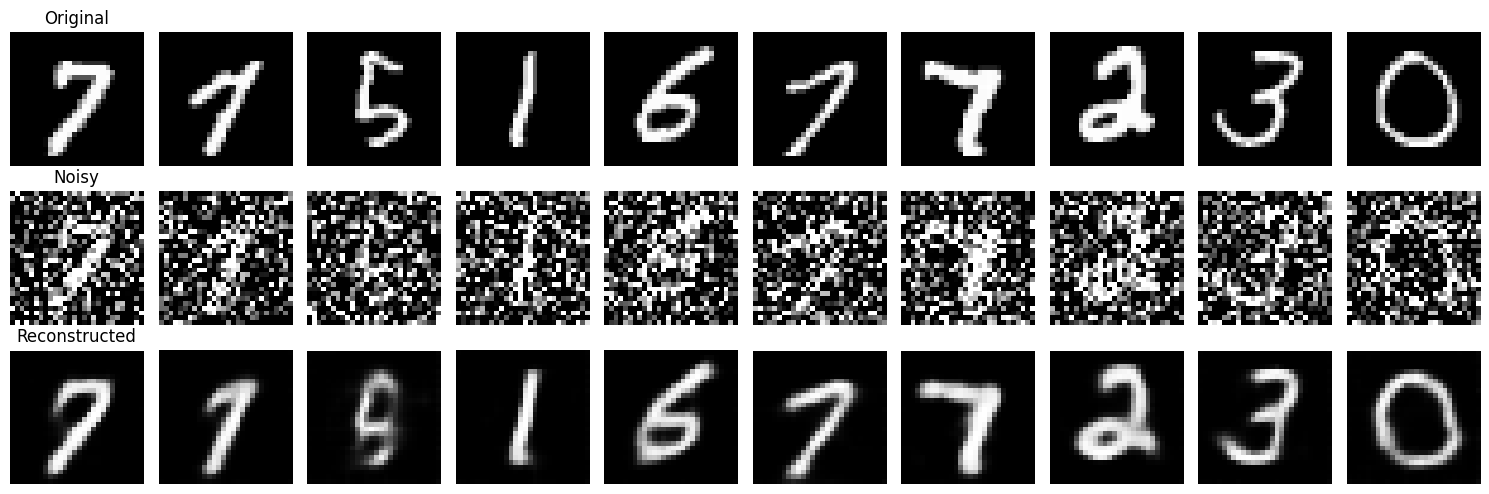

Epoch 6/10, Trainning Loss: 0.0185
Epoch 6/10, Validation Loss: 0.0001


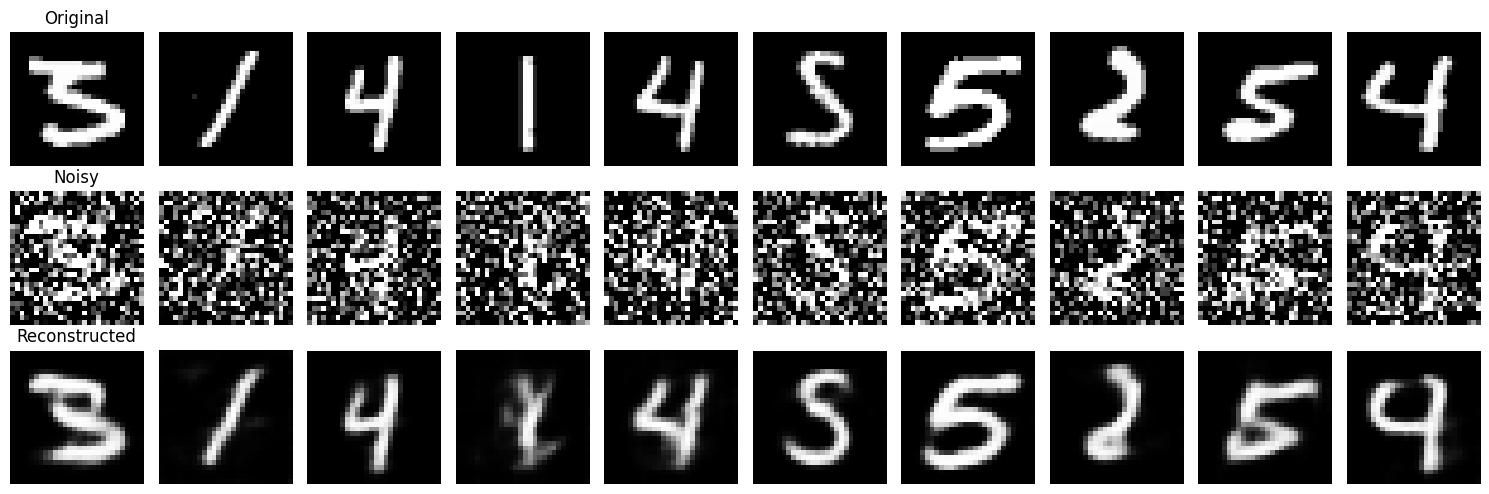

Epoch 7/10, Trainning Loss: 0.0183
Epoch 7/10, Validation Loss: 0.0001


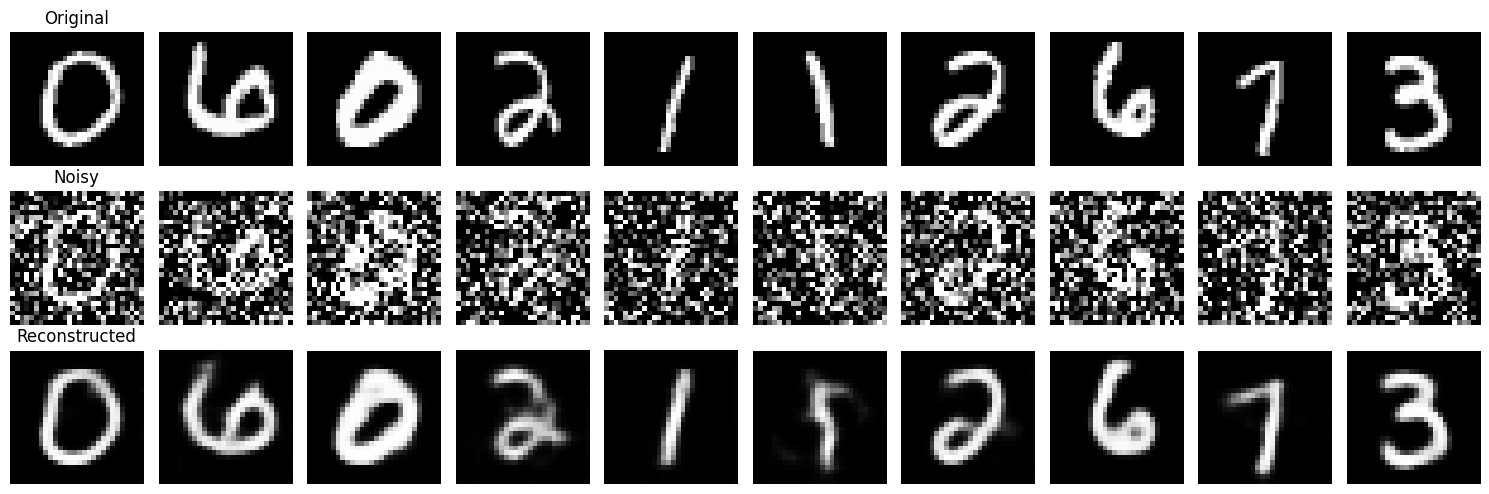

Epoch 8/10, Trainning Loss: 0.0180
Epoch 8/10, Validation Loss: 0.0001


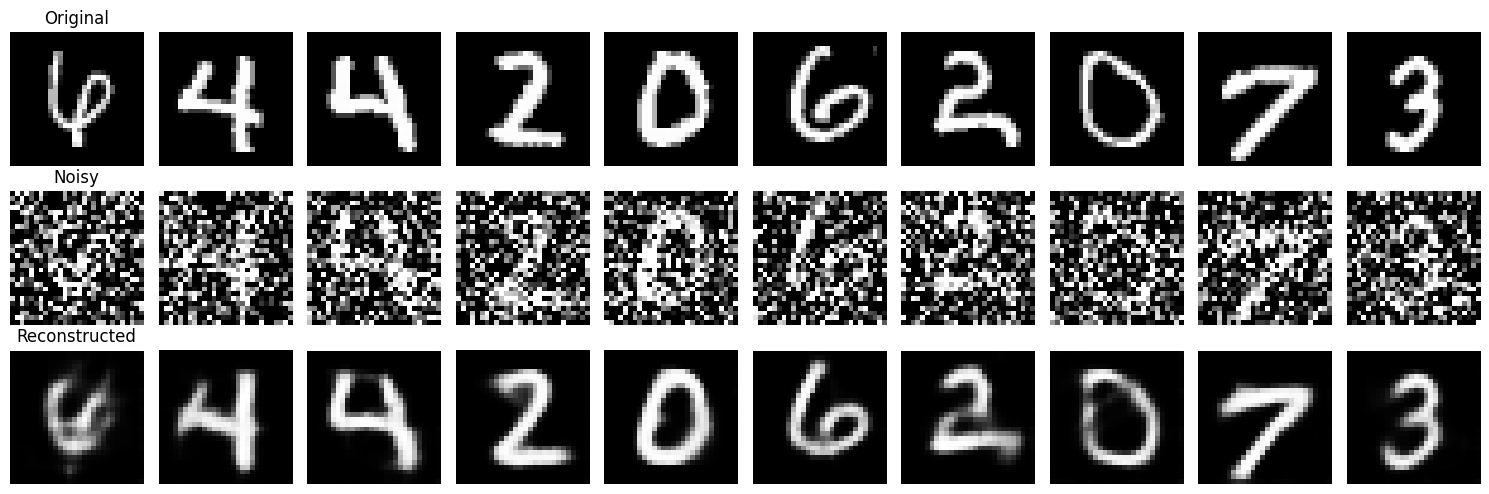

Epoch 9/10, Trainning Loss: 0.0179
Epoch 9/10, Validation Loss: 0.0001


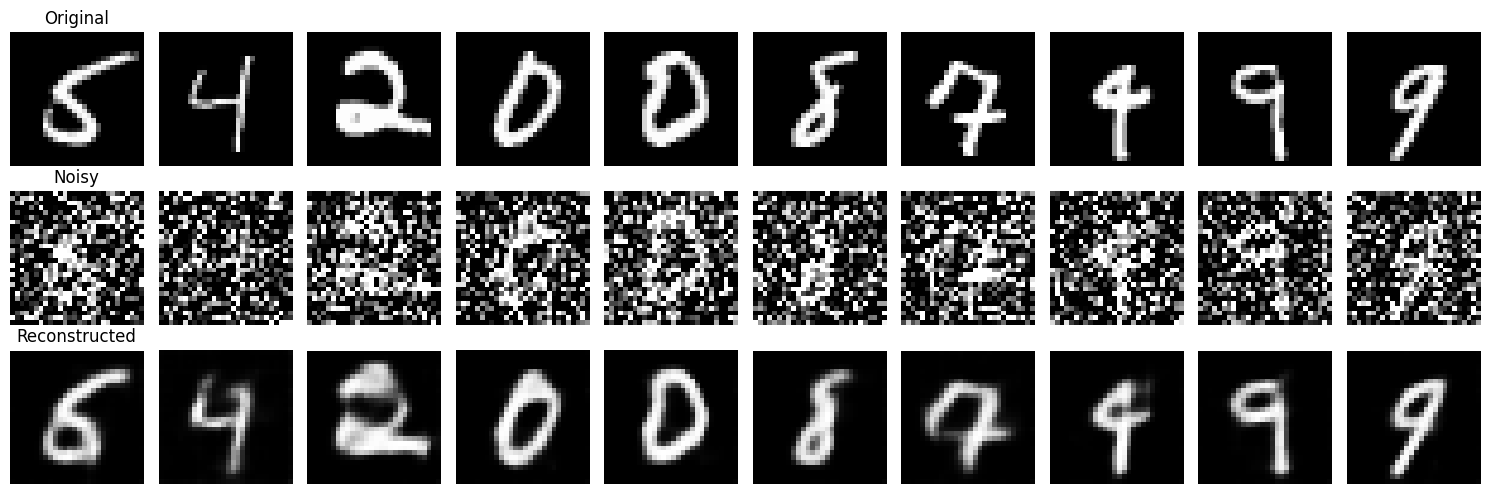

Epoch 10/10, Trainning Loss: 0.0177
Epoch 10/10, Validation Loss: 0.0001


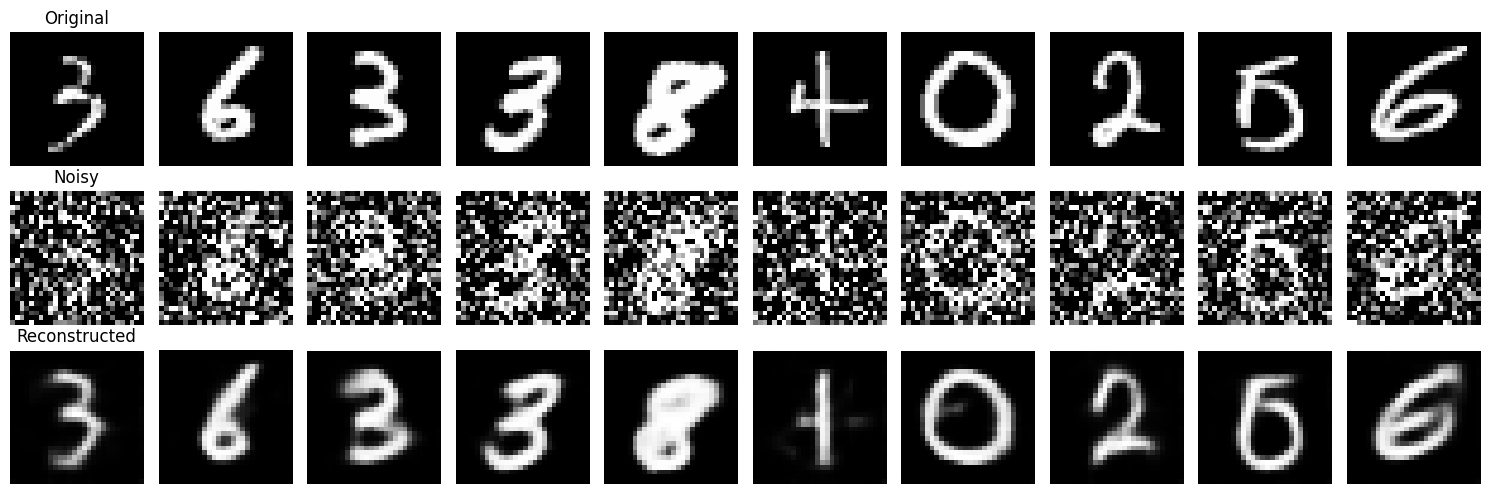

Training with lr=0.001, noise_factor=0.9, weight_decay=0.0001
Epoch 1/10, Trainning Loss: 0.0639
Epoch 1/10, Validation Loss: 0.0003


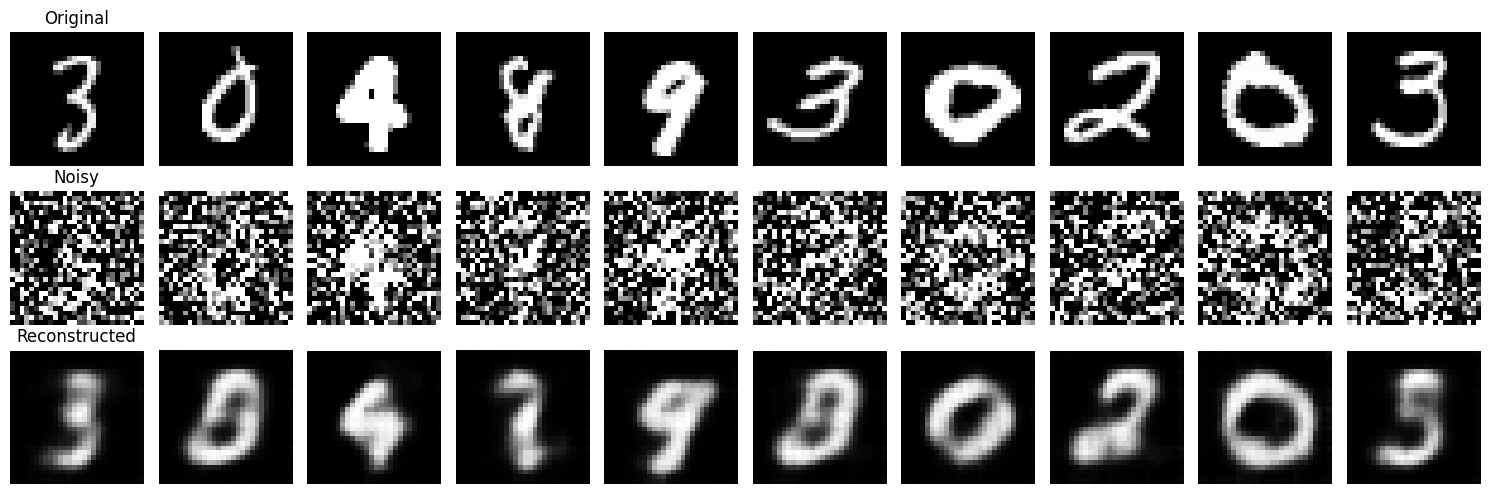

Epoch 2/10, Trainning Loss: 0.0335
Epoch 2/10, Validation Loss: 0.0002


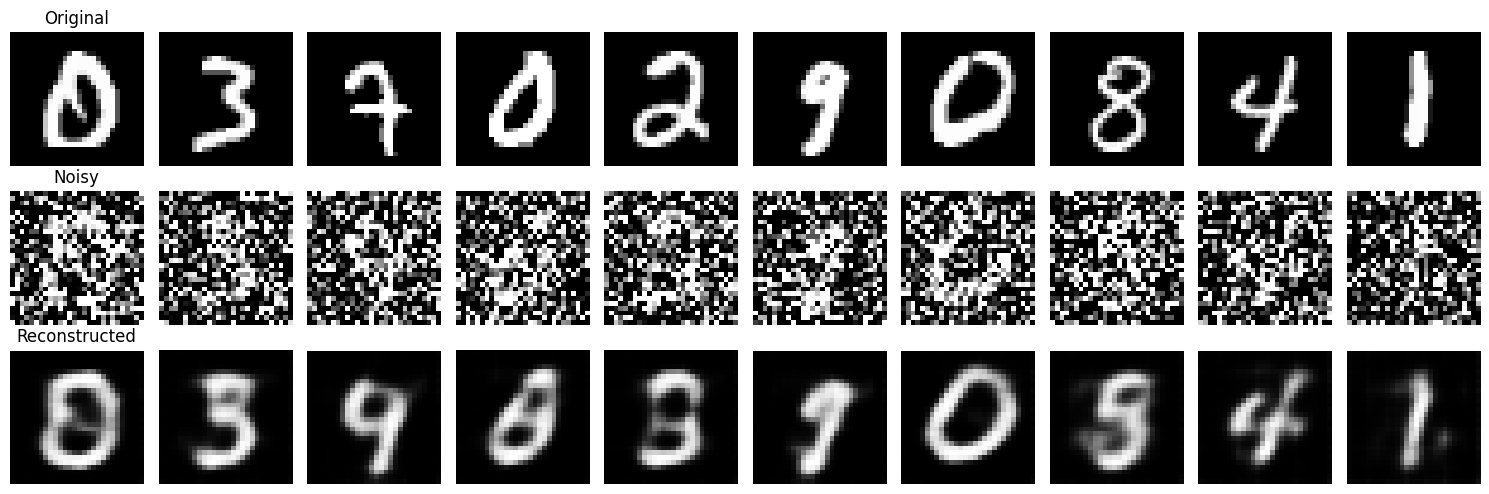

Epoch 3/10, Trainning Loss: 0.0299
Epoch 3/10, Validation Loss: 0.0002


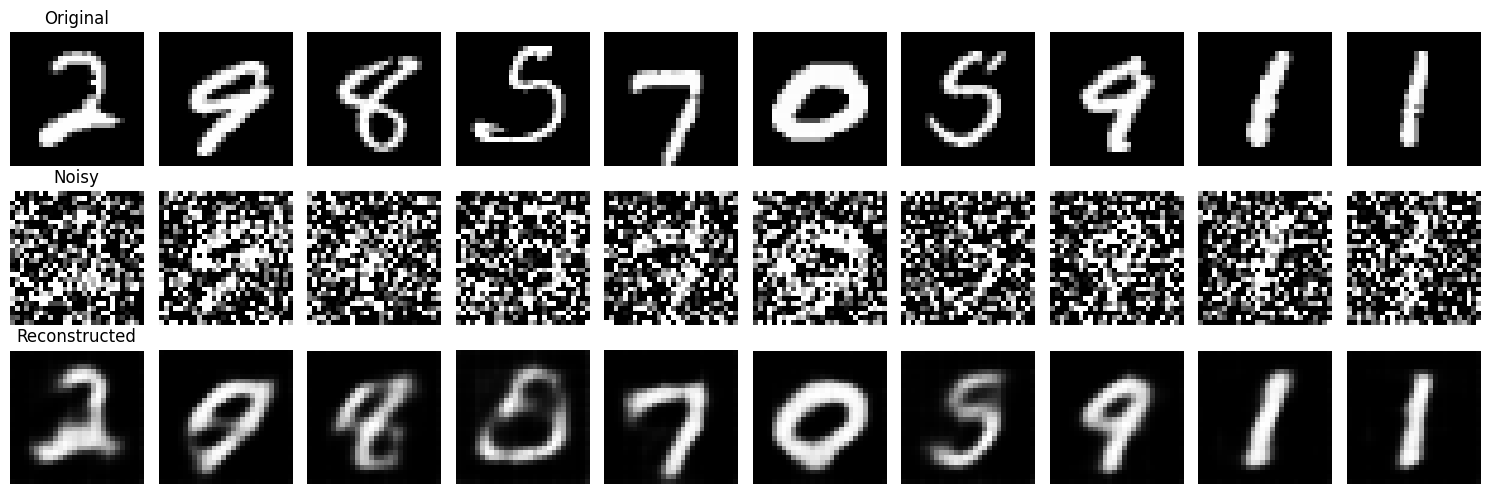

Epoch 4/10, Trainning Loss: 0.0287
Epoch 4/10, Validation Loss: 0.0002


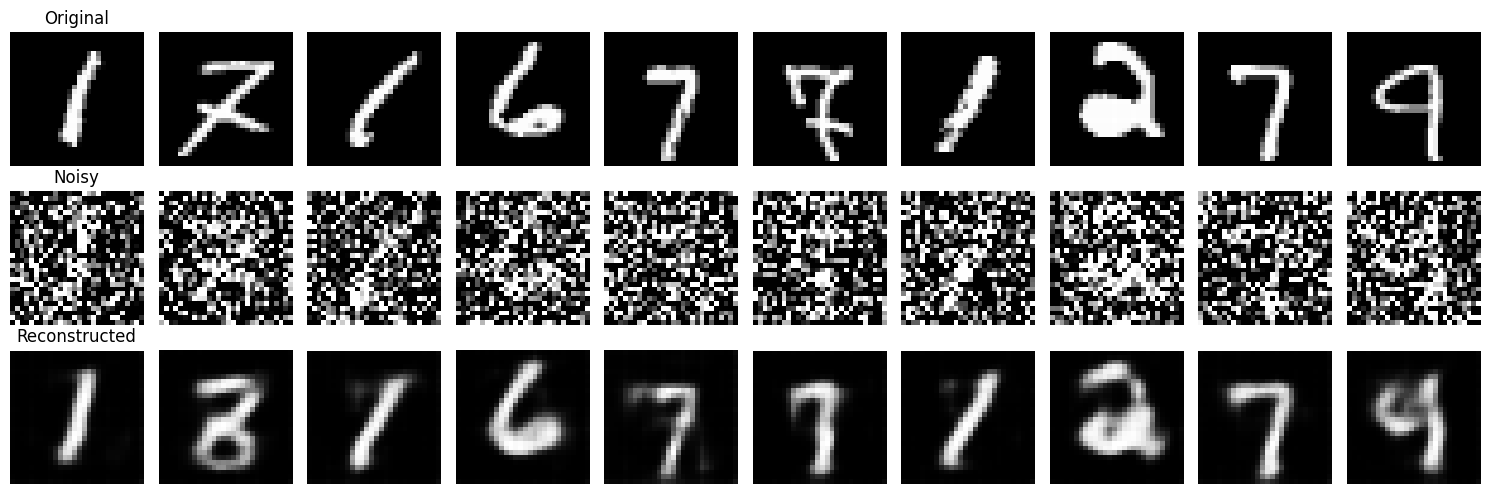

Epoch 5/10, Trainning Loss: 0.0280
Epoch 5/10, Validation Loss: 0.0002


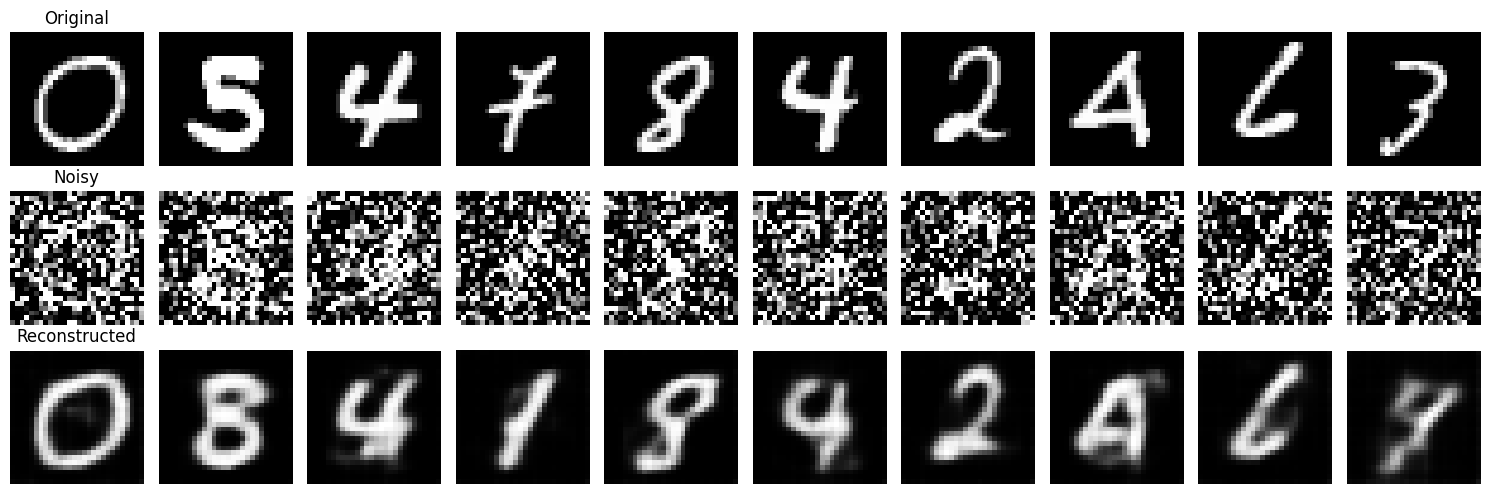

Epoch 6/10, Trainning Loss: 0.0276
Epoch 6/10, Validation Loss: 0.0002


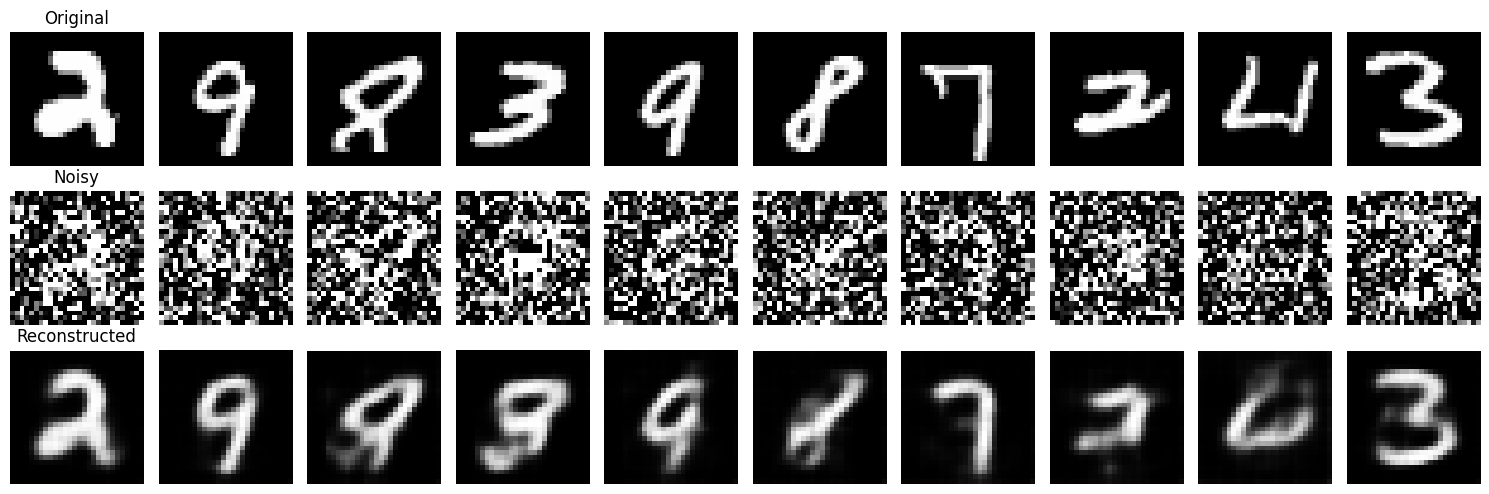

Epoch 7/10, Trainning Loss: 0.0273
Epoch 7/10, Validation Loss: 0.0002


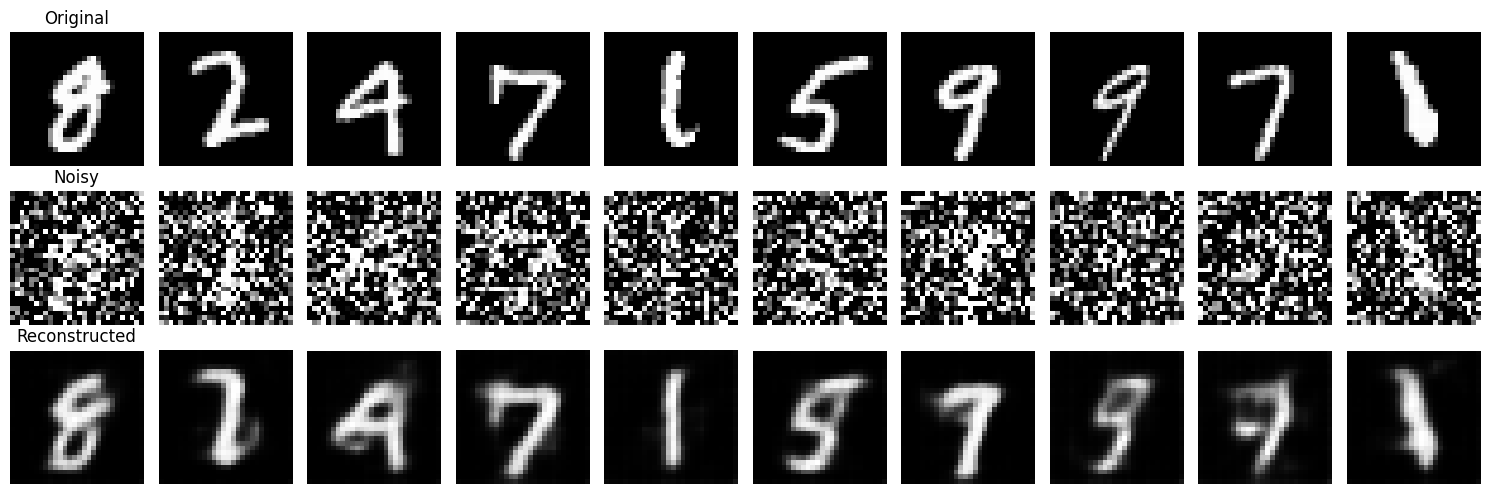

Epoch 8/10, Trainning Loss: 0.0272
Epoch 8/10, Validation Loss: 0.0002


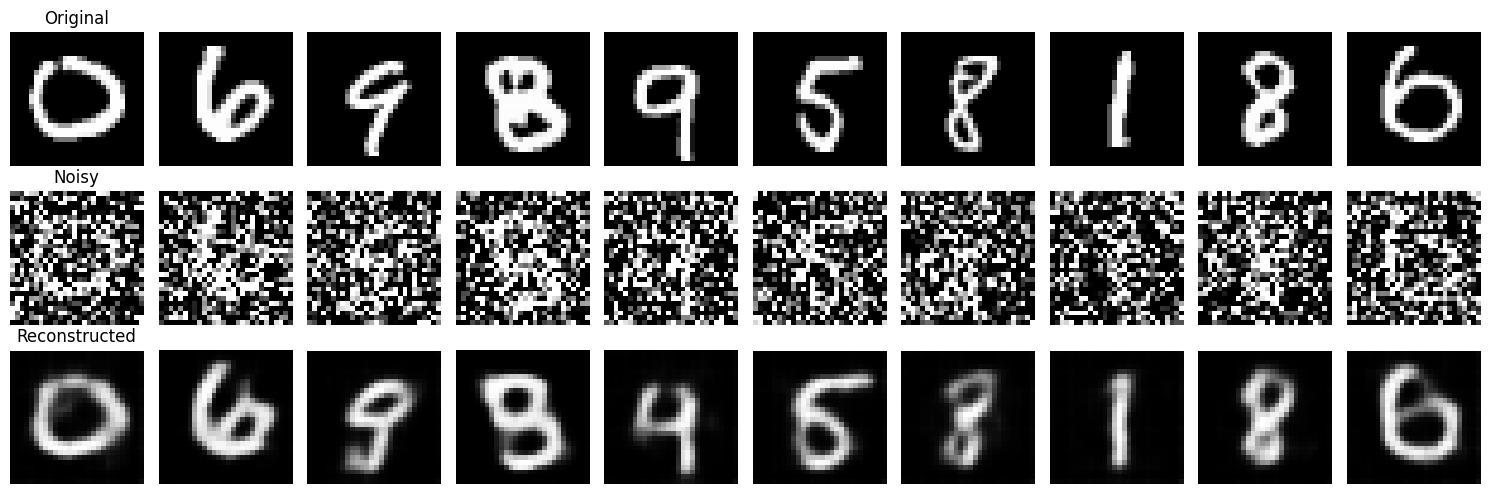

Epoch 9/10, Trainning Loss: 0.0270
Epoch 9/10, Validation Loss: 0.0002


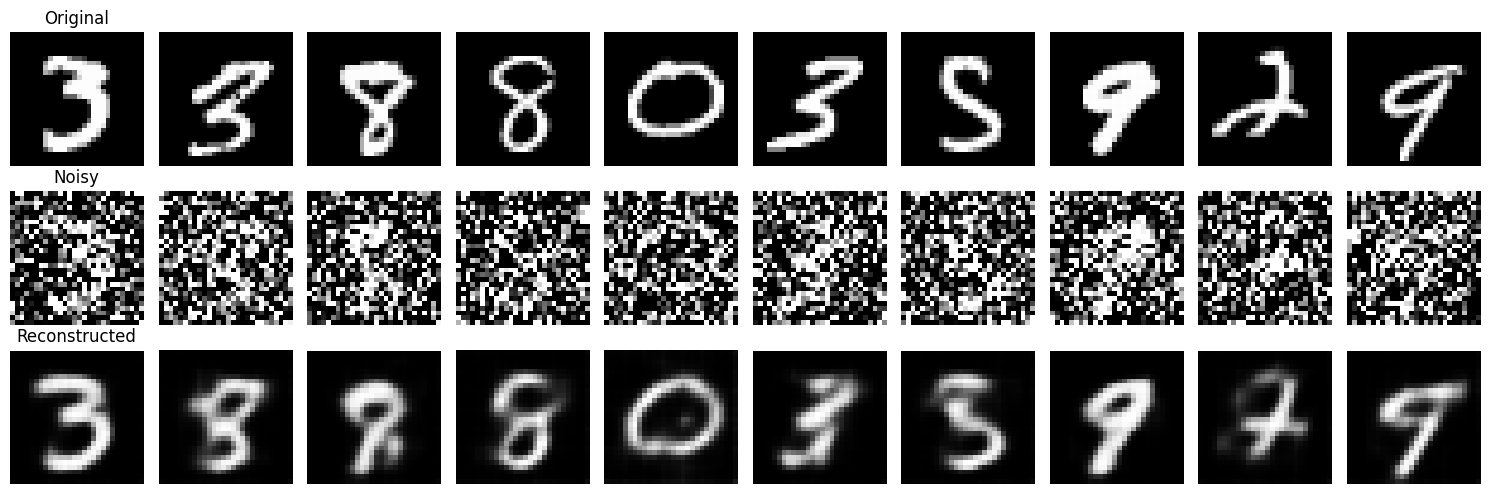

Epoch 10/10, Trainning Loss: 0.0269
Epoch 10/10, Validation Loss: 0.0002


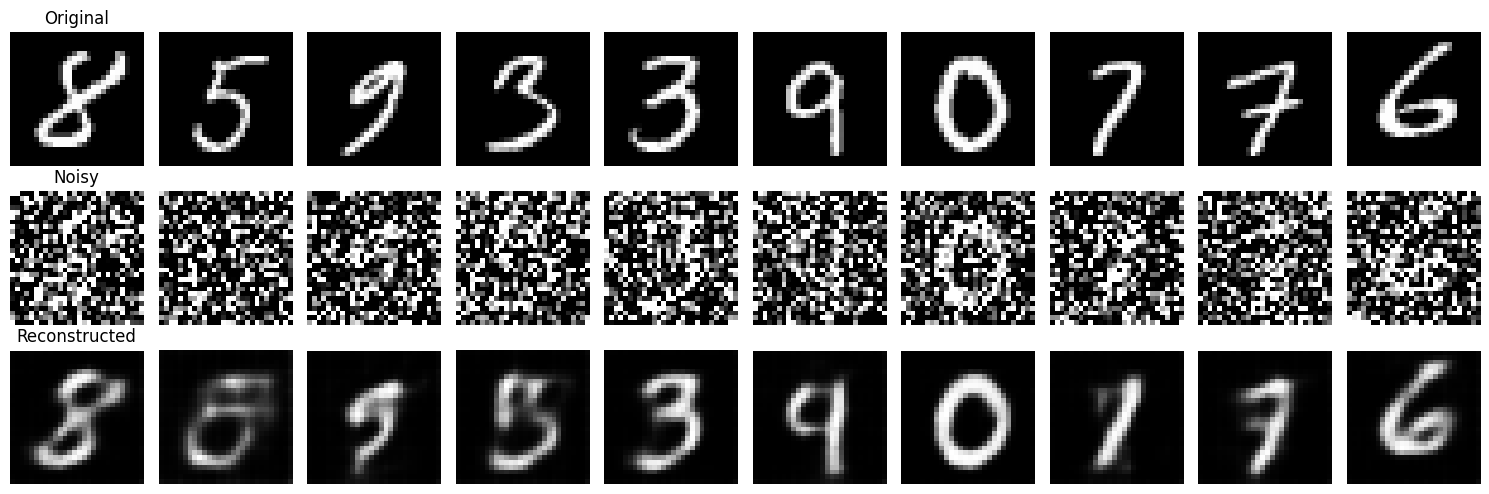

(0.026901184132437844, 0.00016379055039138552)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_epochs = 10
lr = 0.001

# noise_factor=0.5,0.7
weight_decay = 1e-5

for noise_factor in [0.5, 0.7]:
    print(f"Training with lr={lr}, noise_factor={noise_factor}, weight_decay={weight_decay}")
    model = Autoencoder().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_autoencoder_with_noise(model, data_loader, data_loader_valid, num_epochs, noise_factor, criterion, optimizer, True, device)

noise_factor=0.9
weight_decay = 0.0001
print(f"Training with lr={lr}, noise_factor={noise_factor}, weight_decay={weight_decay}")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_autoencoder_with_noise(model, data_loader, data_loader_valid, num_epochs, noise_factor, criterion, optimizer, True, device)

## Resize

In [ ]:
class SuperResolutionAutoencoder(nn.Module):
    def __init__(self, input_size=7):
        super(SuperResolutionAutoencoder, self).__init__()

        stride = input_size // 7
        # Encoder (reduce la resolución)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=stride, padding=1)
        )

        # Decoder (aumenta la resolución)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Valores entre 0 y 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Función para visualizar resultados
def visualize_results_super_resolution_autoencoder(model, data_loader_valid, input_size, device, num_images=10):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        img, _ = next(iter(data_loader_valid))
        img = img.to(device)

        # Crear una versión de baja resolución
        low_res_image = nn.functional.interpolate(img, size=(input_size, input_size), mode='nearest')
        low_res_image = low_res_image.to(device)

        # Reconstruir la imagen
        recon = model(low_res_image)


        # Mover datos a CPU para visualización
        img = img.cpu()
        low_res_image = low_res_image.cpu()
        recon = recon.cpu()

        # Mostrar imágenes
        fig, axes = plt.subplots(3, num_images, figsize=(15, 5))
        for i in range(num_images):
            axes[0, i].imshow(img[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title("Original")

            axes[1, i].imshow(low_res_image[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title("Low Resolution")

            axes[2, i].imshow(recon[i].squeeze(), cmap='gray')
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_title("Reconstructed")

        plt.tight_layout()
        plt.show()


# Función para entrenar el modelo
def train_super_resolution_autoencoder(model, data_loader, num_epochs, input_size, criterion, optimizer, device):
    for epoch in range(num_epochs):
        epoch_loss = 0
        for img, _ in data_loader:
            img = img.to(device)  # Imagen original (28x28)

            # Crear una versión de baja resolución
            low_res_image = nn.functional.interpolate(img, size=(input_size, input_size), mode='nearest')
            low_res_image = low_res_image.to(device)

            # Pasar la imagen de baja resolución al modelo
            recon = model(low_res_image)

            # Calcular la pérdida
            loss = criterion(recon, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(data_loader)  # Promedio por batch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

### 7x7

Epoch 1/10, Loss: 0.0443
Epoch 2/10, Loss: 0.0304
Epoch 3/10, Loss: 0.0294
Epoch 4/10, Loss: 0.0289
Epoch 5/10, Loss: 0.0284
Epoch 6/10, Loss: 0.0281
Epoch 7/10, Loss: 0.0278
Epoch 8/10, Loss: 0.0276
Epoch 9/10, Loss: 0.0274
Epoch 10/10, Loss: 0.0273


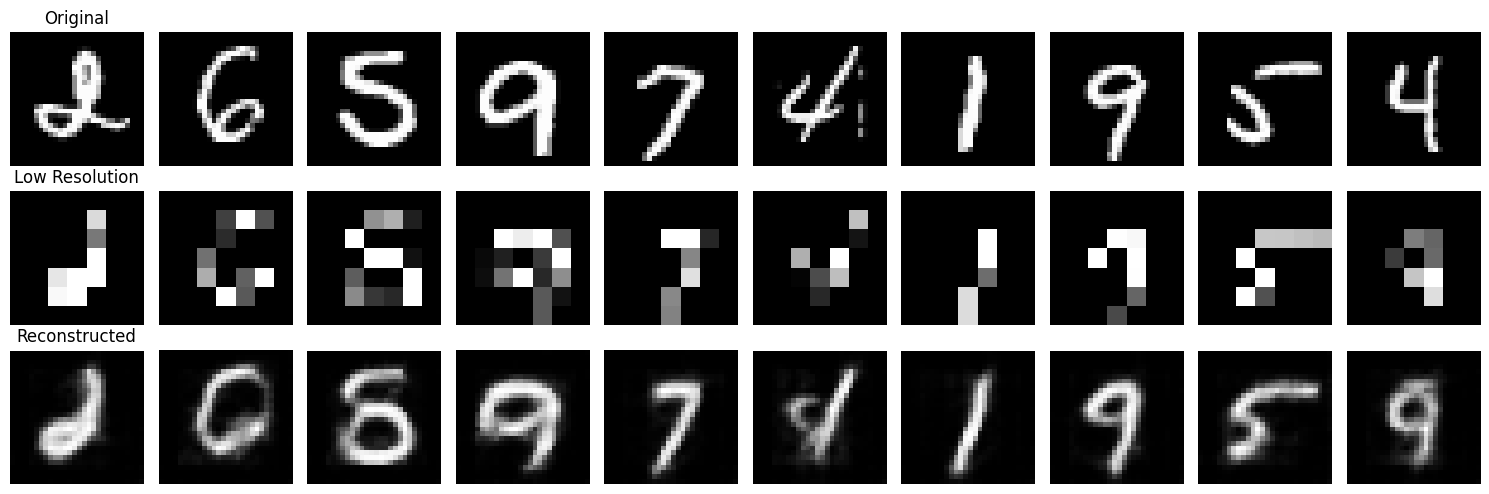

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size=7 # 7x7
num_epochs = 10
lr = 0.001
weight_decay = 1e-5

model = SuperResolutionAutoencoder(input_size=input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

train_super_resolution_autoencoder(model, data_loader, num_epochs, input_size, criterion, optimizer, device)
visualize_results_super_resolution_autoencoder(model, data_loader_valid, input_size, device)

### 14x14

Epoch 1/10, Loss: 0.0086
Epoch 2/10, Loss: 0.0053
Epoch 3/10, Loss: 0.0050
Epoch 4/10, Loss: 0.0049
Epoch 5/10, Loss: 0.0048
Epoch 6/10, Loss: 0.0048
Epoch 7/10, Loss: 0.0048
Epoch 8/10, Loss: 0.0047
Epoch 9/10, Loss: 0.0047
Epoch 10/10, Loss: 0.0047


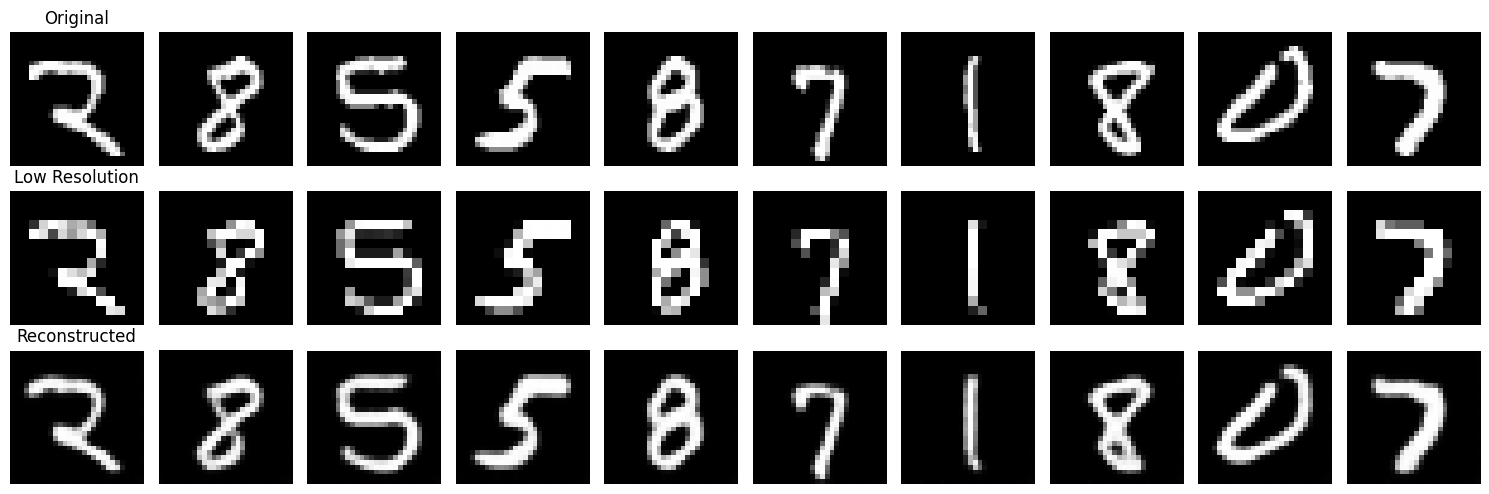

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size=14 # 14x14
num_epochs = 10
lr = 0.001
weight_decay = 1e-5

model = SuperResolutionAutoencoder(input_size=input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

train_super_resolution_autoencoder(model, data_loader, num_epochs, input_size, criterion, optimizer, device)
visualize_results_super_resolution_autoencoder(model, data_loader_valid, input_size, device)